# Distant Reading

Задания для скучающих

## Задание 1: Тематическое моделирование

**Цель:** собрать и запустить на питоне тематическое моделирование и визуализировать топики.

In [ ]:
# todo

## Задание 2: NER + графы

Существуют решения для NER для русского языка, например, парсер Наташа. Давайте реализуем такую штуку: ваш код берет текст, находит в нем все упоминения людей — а потом строит граф, считая связью факт соседства упоминаний на каком-то расстоянии В продвинутой версии — еще и визуализирует его, например, с помощью `networkx` + `matplotlib`.

_Workflow:_

1) загружаем текст,

2) разделяем текст на предложения,

3) при помощи `natasha` выделяем в каждом предложении сущности,

4) собираем словарь "предложение + упоминаемые личности",

5) функция для генерации данных под граф с указанным окном,

6) визуализация данных из п.6 в виде `networkx` графа.

In [77]:
from itertools import product
from natasha import NamesExtractor
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

Загружаем текст:

In [2]:
path_to_text = "../data/01_dostoyevskiy_prestuplenie-i-nakazanie.txt"
with open(path_to_text, "r", encoding="utf-8") as f:
    text = f.read()

Разделяем текст на предложения:

In [3]:
sentences = sent_tokenize(text)
print("\n---\n".join(sentences[:5]))

В начале июля, в чрезвычайно жаркое время, под вечер, один молодой человек вышел из своей каморки, которую нанимал от жильцов в С -- м переулке, на улицу и медленно, как бы в нерешимости, отправился к К -- ну мосту.
---
Он благополучно избегнул встречи с своею хозяйкой на лестнице.
---
Каморка его приходилась под самою кровлей высокого пятиэтажного дома и походила более на шкаф, чем на квартиру.
---
Квартирная же хозяйка его, у которой он нанимал эту каморку с обедом и прислугой, помещалась одною лестницей ниже, в отдельной квартире, и каждый раз, при выходе на улицу, ему непременно надо было проходить мимо хозяйкиной кухни, почти всегда настежь отворенной на лестницу.
---
И каждый раз молодой человек, проходя мимо, чувствовал какое-то болезненное и трусливое ощущение, которого стыдился и от которого морщился.


Выделяем сущности.

В словаре `extracted_entities` будут лежать только те номера предложений, в которых была найдена хотя бы одна сущность, чтобы не занимать много места (текст большой).

В множестве `all_entities` будут все найденные NERы.

In [36]:
def convert_name_to_str(name):
    return "{} {} {}".format(name.first, name.middle, name.last).replace("None", "").strip()

In [38]:
extractor = NamesExtractor()
extracted_entities = {}
all_entities = set()
for i, sent in enumerate(sentences):
    characters = set([convert_name_to_str(m.fact) for m in extractor(sent)])
    if characters != set():
        extracted_entities[i] = characters
        all_entities.update(characters)

In [39]:
print("В Преступлении и наказании {} предложений, из них в {} есть хотя бы одна именованная сущность.".format(
    len(sentences), len(extracted_entities)))
print("Найдено {} сущностей.".format(len(all_entities)))

В Преступлении и наказании 13709 предложений, из них в 2534 есть хотя бы одна именованная сущность.
Найдено 179 сущностей.


Первые 10 примеров предложений с выделенными сущностями:

In [40]:
for i in sorted(extracted_entities.keys())[:9]:
    print("Sentence no. {}\n\t- original: {}\n\t- extracted entities: {}\n---".format(
        i, sentences[i], extracted_entities[i]))

Sentence no. 83
	- original: -- как бы невзначай мелькнуло в уме Раскольникова, и быстрым взглядом окинул он всё в комнате, чтобы по возможности изучить и запомнить расположение.
	- extracted entities: {'раскольников'}
---
Sentence no. 102
	- original: -- Много ль за часы-то, Алена Ивановна?
	- extracted entities: {'алёна ивановна'}
---
Sentence no. 130
	- original: Он смотрел на старуху и не спешил уходить, точно ему еще хотелось что-то сказать или сделать, но как будто он и сам не знал, что именно...
   -- Я вам, Алена Ивановна, может быть, на днях, еще одну вещь принесу... серебряную... хорошую... папиросочницу одну... вот как от приятеля ворочу... -- Он смутился и замолчал.
	- extracted entities: {'алёна ивановна'}
---
Sentence no. 137
	- original: Уж вы сейчас... Прощайте, Алена Ивановна!
	- extracted entities: {'алёна ивановна'}
---
Sentence no. 181
	- original: Такое точно впечатление произвел на Раскольникова тот гость, который сидел поодаль и походил на отставного чиновника.
	

Генерация данных для графа:

In [106]:
def get_graph_data(window):
    """Проходит по данным словаря и собирает данные для невзвешенного 
    неориентированного графа.
    
    :args window (int) — ширина "окна", в котором надо искать совместную
    встречаемость (в обе стороны от предложения).
    """
    G = nx.Graph()
    G.add_nodes_from(all_entities)
    for i in extracted_entities:
        characters_fix = extracted_entities[i]
        min_pair = max(i-window, 0)
        max_pair = min(i+window, len(sentences)-1)
        range_to_look_up = range(min_pair, max_pair+1)
        for neighbor in range_to_look_up:
            if neighbor != i:
                if neighbor in extracted_entities.keys():
                    neighbor_characters = extracted_entities[neighbor]
                    for ch1, ch2 in product(characters_fix, neighbor_characters):
                        if ch1 != ch2:
                            G.add_edge(ch1, ch2)
    lonely = []
    for node, val in G.degree():
        if val < 5:
            lonely.append(node)
    G.remove_nodes_from(lonely)
    return G

In [107]:
G = get_graph_data(3)

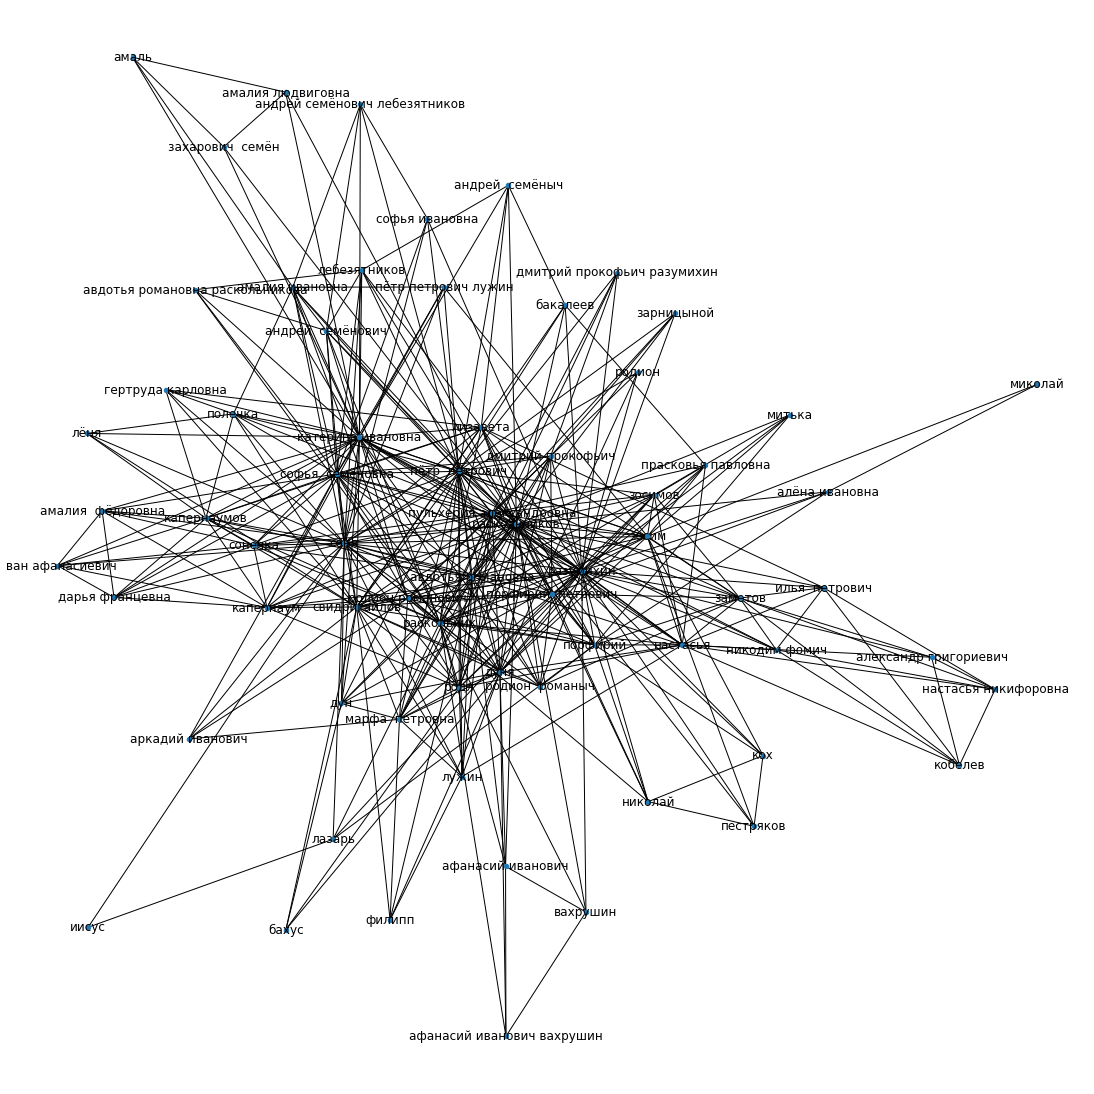

In [108]:
plt.figure(figsize=(15,15))
nx.draw(G, node_size=20, with_labels=True)